## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, RationalQuadratic, Exponentiation, ExpSineSquared
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt

from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel

C:\Users\erikl\Anaconda2\envs\AppliedDataScience\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1

X = Data1.iloc[:,:-1]
Y = Data1.iloc[:,-1:]

Y = Y.values.reshape(1,-1)[0]

Y_log = np.log(Y)
Y = Y_log - Y_log.mean()

X_train = X[:800]
Y_train = Y[:800]

X_test = X[800:]
Y_test = Y[800:]

In [77]:
print("1) The kernel after parameter optimization and fitting to the observed data. (10 pts)")
print("2) The log marginal likelihood of the training data. (5 pts)\n")

kernel = 1. * RBF(length_scale=[.1,.1], length_scale_bounds = (0.1, 0.1)) \
            + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel, random_state=1993, normalize_y=True)
gp.fit(X_train, Y_train)

print("Kernel: ", gp.kernel_)
print("LL-h: ", gp.log_marginal_likelihood_value_)

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)
2) The log marginal likelihood of the training data. (5 pts)

Kernel:  1.3**2 * RBF(length_scale=[0.1, 0.1]) + WhiteKernel(noise_level=0.626)
LL-h:  -995.3017750698403


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)


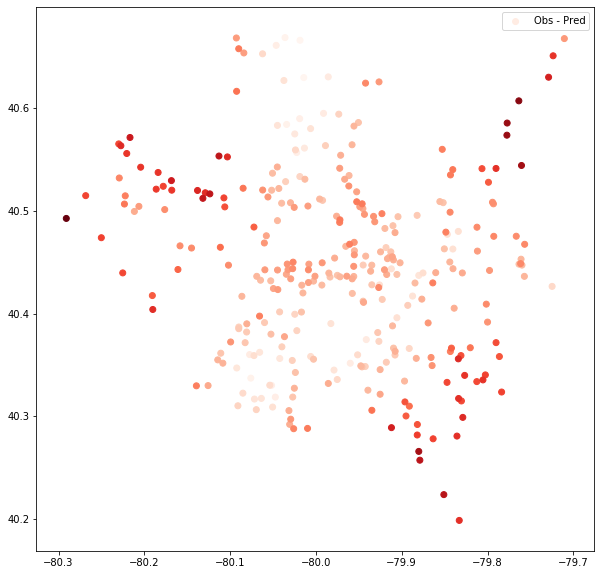

In [266]:
print("3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color"
      " corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations"
      " (with color corresponding to the observed values). (10 pts)")

Y_pred, sigma = gp.predict(X_test, return_std=True)

diffs = (Y_test - Y_pred) / sigma

heatmap = plt.cm.Reds
normalizer = matplotlib.colors.Normalize(vmin = min(diffs), vmax = max(diffs))

fig = plt.figure(figsize=(10,10))
plt.scatter(X_test['Longitude'], X_test['Latitude'], color=heatmap(normalizer(diffs)), label='Obs - Pred')

plt.legend()
plt.show()

In [264]:
print("4) What percentage of sensors have average traffic counts more than two standard deviations higher or"
      " lower than the model predicts given their spatial location? (5 pts)\n")


below_2d = (Y_test < Y_pred - (2*sigma)).sum()
above_2d = (Y_test > Y_pred + (2*sigma)).sum()
print("Percentage 2 STDevs Away: {0:.2f}%".format((below_2d+above_2d)*100/size ))

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

Percentage 2 STDevs Away: 0.99%


5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more than two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)



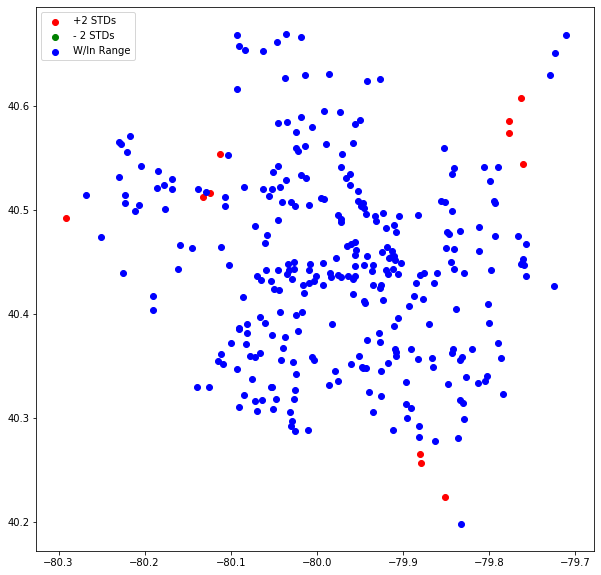

We had no values below 2 STDevs


In [265]:
print("5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values"
      " a) more than two standard deviations higher than predicted,"
      " b) more than two standard deviations lower than predicted, and"
      " c) within two standard deviations of the predicted values. (10 pts)\n")

X_above2d = X_test[( (Y_test - Y_pred) > (2*sigma) )]
X_below_2d = X_test[( (Y_test - Y_pred) < -1*(2*sigma) )]
X_within_2d = X_test[( abs(Y_test - Y_pred) < (2*sigma))]

fig = plt.figure(figsize=(10,10))
plt.scatter(X_above2d['Longitude'], X_above2d['Latitude'], c='r', label='+2 STDs')
plt.scatter(X_below_2d['Longitude'], X_below_2d['Latitude'], c='g', label='- 2 STDs')
plt.scatter(X_within_2d['Longitude'], X_within_2d['Latitude'], c='b', label='W/In Range')

plt.legend()
plt.show()

print("We had no values below 2 STDevs")

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly  <-- **ANOMALY** b/c point (1,0) is no where near the cluster much less the centroid


(35, 2)		Anomaly / Not Anomaly  <-- **NOT ANOMALY** b/c point (35,2) will be within the dense cluster and near the centroid 


(15, 19)	Anomaly / Not Anomaly  <-- **ANOMALY** b/c the cluster itself looks anomalous (too few points) 


(10, 11)	Anomaly / Not Anomaly  <-- **NOT ANOMALY** b/c the point is within the cluster and somewhat near the centroid


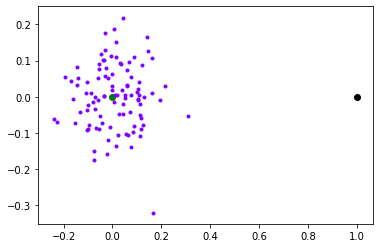

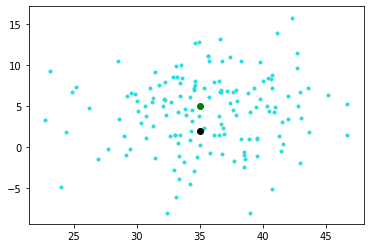

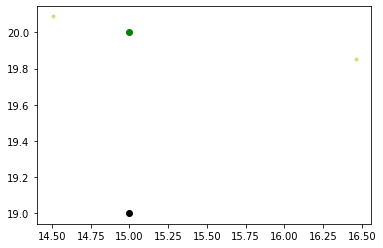

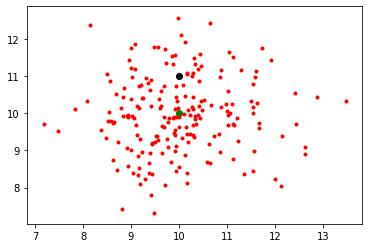

In [18]:
centroids = [(0,0), (35,5), (15,20), (10,10)]
nums = [100, 150, 2, 200]
stds = [0.1, 5, 1,1]

#Points to check
points = [(1,0), (35,2), (15,19), (10,11)]

x = [p[0] for p in centroids]
y = [p[1] for p in centroids]

colors = cm.rainbow(np.linspace(0, 1, len(centroids)))
for center, point, num, std, color in zip(centroids, points, nums, stds, colors):
    plt.scatter(center[0], center[1], color='g')
    x_rand = np.random.normal(loc=center[0], scale=std, size=num)
    y_rand = np.random.normal(loc=center[1], scale=std, size=num)
    for px, py in zip(x_rand, y_rand):
        plt.scatter(px, py, color=color, marker='.')
    
    plt.scatter(point[0], point[1], color='k')
    plt.show()

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [285]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [286]:
outliers = pd.DataFrame()

Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.columns = ['County', '% Fair/Poor Health', 'Phy. Unhealthy Days Per Month',
       'Mentally Unhealthy Days/Month', '% Low birth weight births','% Smokers', '% Obese', 'Food Environment Index',
       '% Physically Inactive', '% With Access To Exercise', 'Excessive Drinking', '% Alcohol-Impaired Driving Deaths',
       'Chlamydia Rate', 'Teen Birth Rate', '% Uninsured', 'Preventable Hosp. Rate', '% Dibetics receiving HbA1c',
       '% Mammography', 'Graduation Rate', '% Some College', '% Unemployed', '% Children in Poverty', '80/20 Income Ratio',
       '% Single-Parent Households', 'Association Rate', 'Violent Crime Rate','Injury Death Rate', 'Average Daily PM2.5',
       '% Severe Housing Problems', '% Drive Alone', '% Long Commute - Drives Alone']

Data2.iloc[:,1:] = Data2.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
Data2.dropna(inplace=True)
Data2.reset_index(drop=True, inplace=True)
Data2.head()

,County,% Fair/Poor Health,Phy. Unhealthy Days Per Month,Mentally Unhealthy Days/Month,% Low birth weight births,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access To Exercise,...,% Children in Poverty,80/20 Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31,7.1,29,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27,7.6,25,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41,5.1,33,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40,7.4,33,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32,8.3,29,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12,85.0,59.0


In [288]:
features = ['County', "% Smokers","% Obese","Violent Crime Rate","80/20 Income Ratio","% Children in Poverty","Average Daily PM2.5"]
data = Data2[features].copy()

for i in data.iloc[:,1:]:
    data[i] = pd.cut(data[i], bins=5, labels=False)
data.head()

,County,% Smokers,% Obese,Violent Crime Rate,80/20 Income Ratio,% Children in Poverty,Average Daily PM2.5
0,"Autauga, Alabama",1,2,0,1,1,3
1,"Baldwin, Alabama",1,2,0,1,1,3
2,"Barbour, Alabama",2,4,0,2,3,3
3,"Bibb, Alabama",2,4,0,1,2,3
4,"Blount, Alabama",1,2,0,1,2,3


In [289]:
print('Part 1: Learn a Bayesian network structure using only the six features\n')
print("(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)\n")
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
for edge in best_model.edges():
    print(edge)

Part 1: Learn a Bayesian network structure using only the six features

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

('% Smokers', '% Obese')
('% Smokers', 'Average Daily PM2.5')
('Violent Crime Rate', '% Children in Poverty')
('% Children in Poverty', '% Smokers')
('% Children in Poverty', '80/20 Income Ratio')


In [290]:
print("(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of"
      " the top counties' names and log-likelihood values. (10 pts)\n")
model = BayesianModel(best_model.edges())
model.fit(data, estimator=MaximumLikelihoodEstimator)
exmp = data.apply(lambda x: LL(x, model), axis=1)
exmp2=pd.Series(exmp)
exmp2.index=data['County']

outliers['BayesNet'] = exmp2.sort_values().head(5).index

exmp2.sort_values().head(5)

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)



County
New York, New York                           -16.608495
San Francisco, California                    -14.827149
Roulette, North Dakota                       -14.686742
Suffolk, Massachusetts                       -14.457849
District of Columbia, District of Columbia   -13.671439
dtype: float64

In [291]:
print("Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.\n")
print("(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster "
      "center and report the five counties which have the longest distances. (10 pts)")

X = Data2.iloc[:,1:]
Y = Data2.iloc[:,0:1]
X_norm = preprocessing.normalize(X)

KM = KMeans(n_clusters = 3, random_state = 1993)
KM.fit_predict(X_norm)

res = pd.DataFrame(KM.transform(X_norm))
res = pd.concat((res, pd.DataFrame( KM.fit_predict(X_norm) ) ), axis=1)
res.columns=list(range(3)) + ["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

res['County'] = Y
# find data records farthest from cluster centers

outliers['KMeans'] = list(res.sort_values("score",ascending=False)[:5]['County'])

res.sort_values("score",ascending=False)[:5]

Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)


,0,1,2,cluster,score,County
841,0.939394,0.891358,0.624167,2,0.624167,"Knott, Kentucky"
2378,0.566779,0.912665,0.889800,0,0.566779,"Nicholas, West Virginia"
1923,0.561495,0.893068,0.821524,0,0.561495,"Grundy, Tennessee"
859,0.826142,0.853900,0.555055,2,0.555055,"Martin, Kentucky"
484,0.795010,0.859854,0.552995,2,0.552995,"Madison, Idaho"


In [292]:
print("(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance)"
      " as the measure of anomalousness. (10 pts)\n")

X = Data2.iloc[:,1:]
Y = Data2.iloc[:,0:1].copy()
X_norm = preprocessing.normalize(X)

GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X_norm)
gm_scores = GM.score_samples(X_norm)

Y['scores'] = gm_scores

outliers['Gaussian'] = list(Y.sort_values(by=['scores'])[:5]['County'])

Y.sort_values(by=['scores'])[:5]


(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)



,County,scores
484,"Madison, Idaho",26.359840
338,"Chattahoochee, Georgia",32.389013
1620,"Holmes, Ohio",33.568056
621,"LaGrange, Indiana",41.923926
2339,"San Juan, Washington",49.698461


In [293]:
print("Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by"
      " the model you chose. (10 pts)\n")

X = Data2.iloc[:,1:]
Y = Data2.iloc[:,0:1].copy()
X_norm = preprocessing.normalize(X)

clf = LocalOutlierFactor(n_neighbors = 3)
clf.fit_predict(X_norm)


Y['scores'] = clf.negative_outlier_factor_

outliers['LOF'] = list(Y.sort_values(by=['scores'])[:5]['County'])

Y.sort_values(by=['scores'])[:5]['County']

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)



522               Hamilton, Illinois
913          East Carroll, Louisiana
2299    Manassas Park City, Virginia
1095           Clearwater, Minnesota
2110                    Nolan, Texas
Name: County, dtype: object

Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

Only the County of Madison, Idaho appears in more than one anomality cluster
Outliers seemed to be picked around rates of chlamydia and violent crime
For example: 
 
BayesNet outliers were big wealthy cities, which makes sense, large population, bigger crime, plus taking other features out probably contributed to these cities being outliers.
KMeans outliers although similar in violent crime, outliers are severely lower in chlamydia rates
Gaussian outliers are both low in chlamydia rates and violent crimes
LOF outliers are both higher in chlamydia and violent crime rates than the rest, but slightly


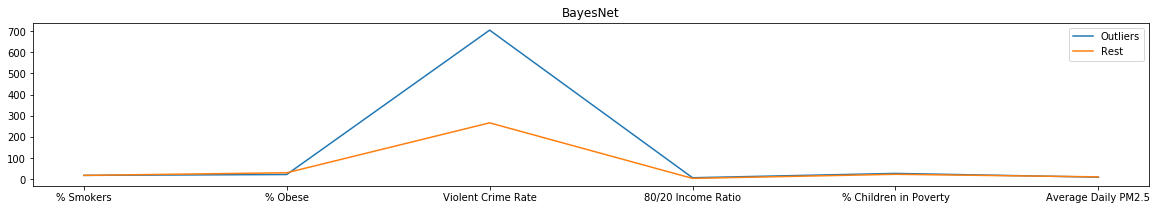

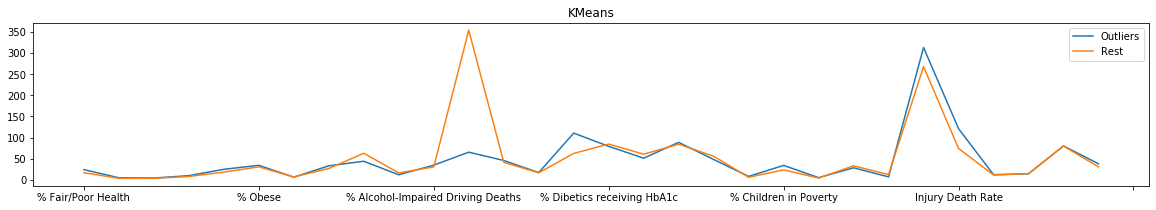

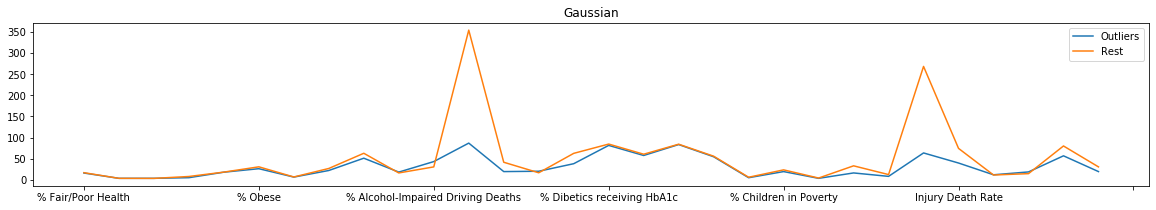

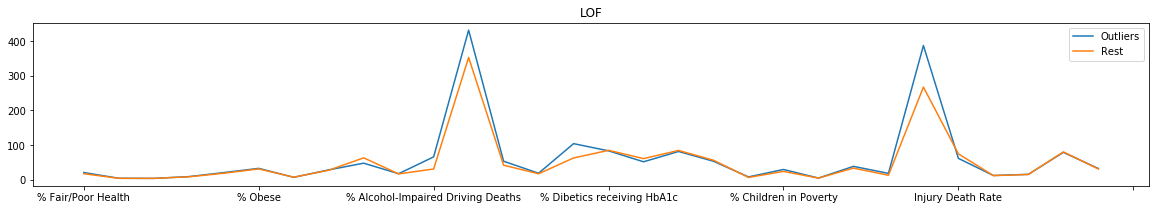

,BayesNet,KMeans,Gaussian,LOF
0,"New York, New York","Knott, Kentucky","Madison, Idaho","Hamilton, Illinois"
1,"San Francisco, California","Nicholas, West Virginia","Chattahoochee, Georgia","East Carroll, Louisiana"
2,"Roulette, North Dakota","Grundy, Tennessee","Holmes, Ohio","Manassas Park City, Virginia"
3,"Suffolk, Massachusetts","Martin, Kentucky","LaGrange, Indiana","Clearwater, Minnesota"
4,"District of Columbia, District of Columbia","Madison, Idaho","San Juan, Washington","Nolan, Texas"


In [296]:
print("Part 4: Compare and contrast the results from the different models. Were there some counties that were found"
      " to be anomalous in some models and not in others? Please provide some intuitions on why each county was found"
      " to be anomalous. (5 pts)\n")

print("Only the County of Madison, Idaho appears in more than one anomality cluster")
print("Outliers seemed to be picked around rates of chlamydia and violent crime")
print("For example: \n ")
print("BayesNet outliers were big wealthy cities, which makes sense, large population, bigger crime, plus taking other"
      " features out probably contributed to these cities being outliers.")
print("KMeans outliers although similar in violent crime, outliers are severely lower in chlamydia rates")
print("Gaussian outliers are both low in chlamydia rates and violent crimes")
print("LOF outliers are both higher in chlamydia and violent crime rates than the rest, but slightly")

for col in ["BayesNet","KMeans","Gaussian","LOF"]:
    counties = list(outliers[col])
    plt.figure(figsize=(20,3))
    plt.title(col)
    if col == 'BayesNet':
            Data2[Data2['County'].isin(counties)][features].mean().plot(label="Outliers")
            Data2[~Data2['County'].isin(counties)][features].mean().plot(label='Rest')
    else:
        Data2[Data2['County'].isin(counties)].iloc[:,1:].mean().plot(label="Outliers")
        Data2[~Data2['County'].isin(counties)].iloc[:,1:].mean().plot(label='Rest')
    plt.legend()
    plt.show()
    
outliers